# Pulsar Classification Analysis

# Imports

In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

# Models 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier
from xgboost import XGBClassifier

# Data Processing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA


# Model Processing
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# K Best columns
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif

# Functions

In [12]:
def check_for_dupes_nans(df:pd.DataFrame):
    """
    Checks for dupes and nulls
    """
    amount_of_dupes = df.duplicated().sum()
    print(f"Null Count: {df.isna().sum()}")
    print(f"Dupe Count: {amount_of_dupes}")

def check_class_imbalance(df:pd.DataFrame, target:pd.Series, col:str):
  counter = Counter(target)
  for k,v in counter.items():
    per = v/len(target) * 100
    print("Class=%s, Count=%d, Percentage=%.3f%%" % (k,v, per))
  
  ax = df[col].value_counts().sort_index().plot(
  kind="bar", 
  title="Count of Reviews by Target", 
  figsize=(10,5)
  )
  ax.set_xlabel(col)
  plt.show()

def check_for_dupes_nans(df:pd.DataFrame):
    """
    Checks for dupes and nulls
    """
    amount_of_dupes = df.duplicated().sum()
    print(f"Null Count: {df.isna().sum()}")
    print(f"Dupe Count: {amount_of_dupes}")

def evaluate_model(X:pd.Series, y:pd.Series, model):
    """
    This function takes in X, y values
    scores model performance based on
    subsets of data

    Returns:
        scores of models
    """
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
    
    metric = make_scorer(f1_score)
    scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
    return scores

# EDA Analysis

In [4]:
df = pd.read_csv("/Users/maukanmir/Downloads/Pulsar_cleaned.csv")
df

,Mean_Integrated,EK,Skewness,Mean_DMSNR_Curve,SD_DMSNR_Curve,EK_DMSNR_Curve,Skewness_DMSNR_Curve,Class
0,140.562500,1.502969,-0.699648,3.199833,19.110426,7.975532,74.242225,0
1,102.507812,0.788423,-0.515088,1.677258,14.860146,10.576487,127.393580,0
2,103.015625,0.323558,1.051164,3.121237,21.744669,7.735822,63.171909,0
3,136.750000,0.958983,-0.636238,3.642977,20.959280,6.896499,53.593661,0
4,88.726562,1.232198,1.123492,1.178930,11.468720,14.269573,252.567306,0
...,...,...,...,...,...,...,...,...
14982,96.000000,0.537495,0.281344,1.871237,15.833746,9.634927,104.821623,0
14983,136.429688,1.349991,-0.738123,1.296823,12.166062,15.450260,285.931022,0
14984,122.554688,0.316006,0.323061,16.409699,44.626893,2.945244,8.297092,0
14985,119.335938,0.213253,-0.743025,21.430602,58.872000,2.499517,4.595173,0


# Check for Dupes and Nulls

In [6]:
check_for_dupes_nans(df)

Null Count: Mean_Integrated         0
EK                      0
Skewness                0
Mean_DMSNR_Curve        0
SD_DMSNR_Curve          0
EK_DMSNR_Curve          0
Skewness_DMSNR_Curve    0
Class                   0
dtype: int64
Dupe Count: 0


# Check for class Imbalance

Class=0, Count=14679, Percentage=97.945%
Class=1, Count=308, Percentage=2.055%


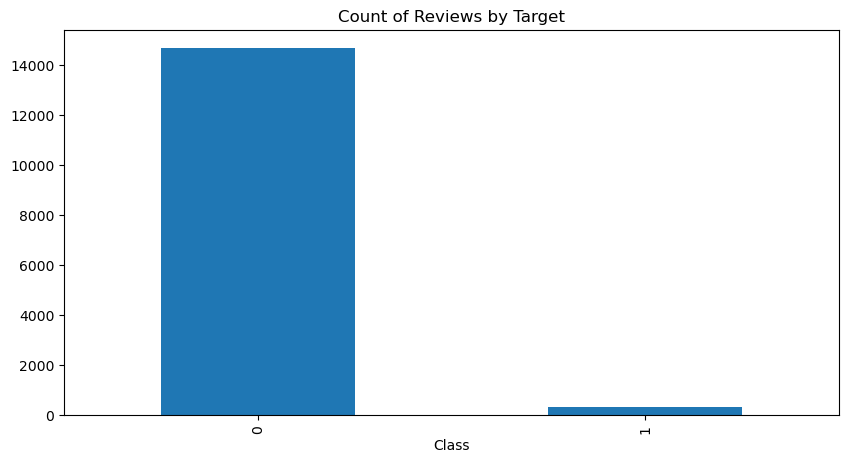

In [8]:
check_class_imbalance(df, df['Class'], "Class")

# We have a severe class imbalance which will require over sampling methods in order to properly evaluate our model.

In [9]:
df.dtypes

Mean_Integrated         float64
EK                      float64
Skewness                float64
Mean_DMSNR_Curve        float64
SD_DMSNR_Curve          float64
EK_DMSNR_Curve          float64
Skewness_DMSNR_Curve    float64
Class                     int64
dtype: object

In [10]:
df.describe()

,Mean_Integrated,EK,Skewness,Mean_DMSNR_Curve,SD_DMSNR_Curve,EK_DMSNR_Curve,Skewness_DMSNR_Curve,Class
count,14987.000000,14987.000000,14987.000000,14987.000000,14987.000000,14987.000000,14987.000000,14987.000000
mean,115.941758,0.768933,0.389529,3.775272,20.419064,8.965458,106.490589,0.020551
std,16.790736,0.639350,0.880771,4.052198,9.324754,3.100184,72.938789,0.141881
min,39.976562,0.000038,-1.207550,0.650502,9.956068,-0.649044,-1.630794,0.000000
25%,104.734375,0.296824,-0.201098,1.890886,14.285618,6.941751,53.175677,0.000000
50%,116.554688,0.636305,0.148028,2.600334,17.478642,8.832803,92.117154,0.000000
75%,127.617188,1.080049,0.697814,3.896739,23.119246,10.813328,142.364947,0.000000
max,186.023438,6.335349,4.238586,79.635452,62.141842,18.535485,364.501595,1.000000


# Visuals

<AxesSubplot:>

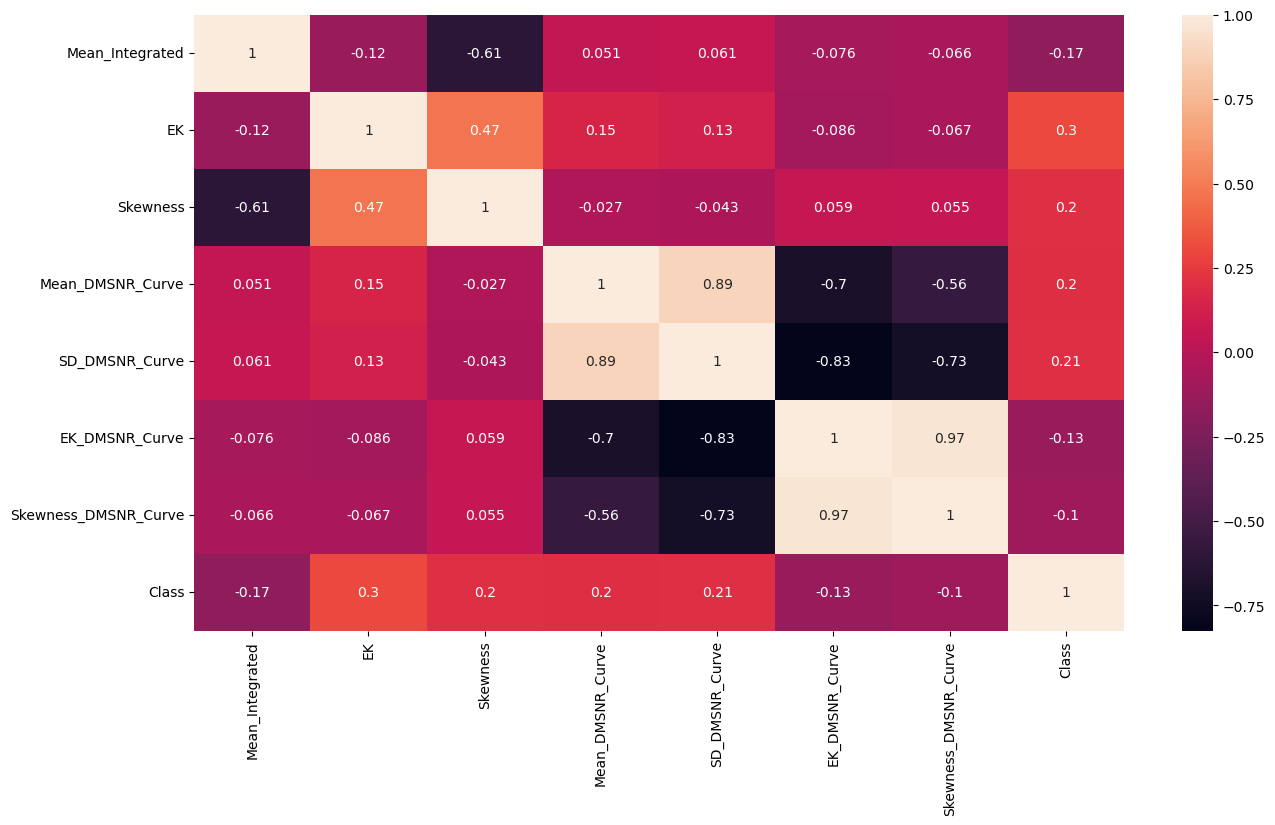

In [13]:
plt.figure(figsize=(15, 8))
sns.heatmap(data=df.corr(), annot=True)